1)взять CIFAR100 

2)обучить с нуля resnet18

3.1)выделить 10 легких и 10 тяжелых классов

3.2)менять долю их представителей в выборке и следить за общим качеством на валидации

4.1)для каждого объекта посчитать его лосс (в итоговой модели)

4.2)менять их долю (убрать первые 5% самых легких,10% и т.д.) и следить за общим качеством на валидации

5)повторить 1)-4) для TinyImageNet

In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

from tqdm import tqdm

In [3]:
set_seed(1000)

In [4]:
def prepare_transforms(augments=[True, False]):
    data_mean = (0.5071, 0.4865, 0.4409)
    data_std = (0.2673, 0.2564, 0.2762)
    # types of transform: with augmentation and without
    transform_augmented = transforms.Compose([
        #transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    transform_clean = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    # choose transform according func params
    train_transform = transform_augmented if augments[0] else transform_clean
    test_transform = transform_augmented if augments[1] else transform_clean

    return train_transform, test_transform

In [5]:
def get_loaders(data_dir='cifar-100', batch_size=32, augments=[True, False], shuffles=[False, False]):
    train_transform, test_transform = prepare_transforms(augments)
    train_dataset = datasets.CIFAR100(
            data_dir, train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR100(
            data_dir, train=False, transform=test_transform, download=True)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, shuffle=shuffles[0],
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)

    return train_loader, test_loader

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
train_loader,test_loader = get_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
from torchvision.models import resnet18

model = resnet18()
model.fc = nn.Linear(512,100)
optimizer = torch.optim.SGD(model.parameters(),lr=0.02)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

loss_function = nn.CrossEntropyLoss()
model.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [9]:
def train_test_cycle(model,train_loader,test_loader,optimizer,scheduler,loss_function,n_epochs=10,print_losses=False):
  losses_history = { 'train': [], 'test': [] }
  train_len = len(train_loader)
  val_len = len(test_loader)
  for i in range(n_epochs):
    model.train()
    train_loss = 0
    for x,y in tqdm(train_loader):
      optimizer.zero_grad()
      x, y = x.to(device), y.to(device)
      preds = model(x)
      loss = loss_function(preds,y)
      train_loss += loss
      loss.backward()
      optimizer.step()
    scheduler.step()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
      for x,y in  tqdm(test_loader):
         x, y = x.to(device), y.to(device)
         preds = model(x)
         loss = loss_function(preds,y)
         val_loss += loss    
    
    losses_history['train'].append(train_loss / train_len)
    losses_history['test'].append(val_loss / val_len)

    if print_losses:
      print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }')
   
  return model,losses_history

In [10]:
model,losses_history = train_test_cycle(model,train_loader,test_loader,optimizer,scheduler,loss_function,n_epochs=5)

100%|██████████| 313/313 [00:01<00:00, 240.44it/s]


In [11]:
torch.save(model.state_dict(), 'model_for_losses.pth')

In [12]:
val_acc = 0
model.eval()
with torch.no_grad():
  for x,y in test_loader:
    x,y = x.to(device), y.to(device)
    logits = model(x)
    preds = logits.max(1)[1]
    val_acc += (y == preds).sum()

val_acc / len(test_loader) / 32

tensor(0.3770, device='cuda:0')

In [13]:
class_acc_train = {i: 0 for i in range(100)}
class_acc_test = {i: 0 for i in range(100)}

In [14]:
for x,y in train_loader:
    x,y = x.to(device), y.to(device)
    logits = model(x)
    preds = logits.max(1)[1]
    for (predicted,target) in zip(preds,y):
      if predicted == target:
        class_acc_train[target.item()] += 1. / 500 

for x,y in test_loader:
    x,y = x.to(device), y.to(device)
    logits = model(x)
    preds = logits.max(1)[1]
    for (predicted,target) in zip(preds,y):
      if predicted == target:
        class_acc_test[target.item()] += 1. / 100

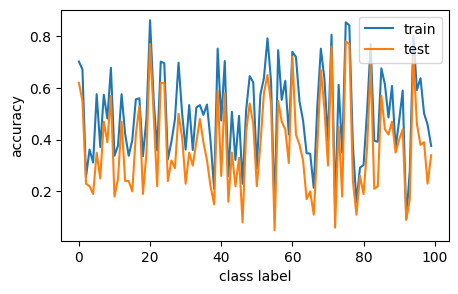

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 5, 3

def plot_dict(dict_of_values,label):
  x_s = dict_of_values.keys()
  y_s = dict_of_values.values()
  plt.plot(x_s,y_s,label=label)
  plt.xlabel('class label')
  plt.ylabel('accuracy')
  plt.legend()

plot_dict(class_acc_train,label='train')
plot_dict(class_acc_test,label='test')

In [16]:
sorted_by_test_acc = sorted(class_acc_test.items(),key=lambda x:x[1])

print('hard labels and their acc',[(i,round(j,3)) for (i,j) in sorted_by_test_acc[:10]])
print('-'*20)
print('easy labels and their acc',[(i,round(j,3)) for (i,j) in sorted_by_test_acc[-10:]])

hard labels and their acc [(55, 0.05), (72, 0.06), (46, 0.08), (92, 0.09), (66, 0.11), (78, 0.11), (38, 0.15), (42, 0.16), (64, 0.17), (93, 0.17)]
--------------------
easy labels and their acc [(24, 0.62), (53, 0.65), (68, 0.67), (82, 0.69), (60, 0.72), (94, 0.72), (71, 0.76), (20, 0.77), (76, 0.77), (75, 0.78)]


In [17]:
hard_classes = [label for (label,acc) in sorted_by_test_acc[ :20] ]
easy_classes = [label for (label,acc) in sorted_by_test_acc[-20:] ]

In [18]:
def get_train_loader(data_dir,mode,fraction,batch_size, augment=True, shuffle=True, args=None):
    '''
    mode = 'easy' or 'hard' -> what type of label we exclude
    fraction -> how many samples we exclude (and remains (1-fraction)*100% )
    '''
    train_transform, test_transform = prepare_transforms(augments=[augment,False])
    data_dir = 'cifar-100'
    train_dataset = datasets.CIFAR100(data_dir, train=True, transform=train_transform, download=True)
    X_all,y_all = train_dataset.data, torch.LongTensor(train_dataset.targets)

    X_all_sampled, y_all_sampled = [], []
    classes_of_interest = easy_classes if mode == 'easy' else hard_classes

    for c in torch.unique(y_all):
        X_all_c, y_all_c = X_all[y_all==c], y_all[y_all==c]
        num_samples = len(X_all_c)
        last_index = int(num_samples*(1-fraction*int(c in classes_of_interest)))
        num_samples = len(X_all_c)
        sampled_indices = torch.randperm(num_samples)[:last_index]
        X_all_sampled.append(X_all_c[sampled_indices])
        y_all_sampled.append(y_all_c[sampled_indices]) 
        
    X_all_sampled = np.concatenate(X_all_sampled, axis=0)
    y_all_sampled = list(torch.cat(y_all_sampled, dim=0).numpy())

    train_dataset.data = X_all_sampled
    train_dataset.targets = y_all_sampled

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, shuffle=shuffle,
        pin_memory=True, num_workers=2,
    )
    return train_loader

In [19]:
data_dir = 'cifar-100'
train_loader = get_train_loader(data_dir,mode='hard',fraction=0.1,
                    batch_size=32, augment=False, shuffle=True)

Files already downloaded and verified


In [20]:
length = 0
for x,_ in train_loader:
  length += len(x)

length

49000

In [21]:
N_EPOCHS = 10

In [22]:
def compute_val_acc(model,val_loader):
  val_acc = 0
  model.eval()
  with torch.no_grad():
    for x,y in test_loader:
      x,y = x.to(device), y.to(device)
      logits = model(x)
      preds = logits.max(1)[1]
      val_acc += (y == preds).sum() / len(y)

  return val_acc / len(test_loader) 

In [23]:
modes = ['easy', 'hard']
modes_history = {'easy':{},'hard':{}}
fractions = [0,0.2,0.4,0.6,0.8]

for fraction in fractions:
  for mode in modes:
    reduced_train_loader = get_train_loader(data_dir,mode=mode,fraction=fraction,batch_size=32)
    model = resnet18()
    model.fc = nn.Linear(512,100)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    model,losses = train_test_cycle(model,reduced_train_loader,test_loader,optimizer,scheduler,loss_function,n_epochs=N_EPOCHS)
    modes_history[mode][fraction] = losses

Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 205.29it/s]


Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 219.69it/s]


Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 191.67it/s]


Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 187.77it/s]


Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 216.26it/s]


Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 184.05it/s]


Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 197.74it/s]


Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 175.61it/s]


Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 159.78it/s]


Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 169.64it/s]


In [25]:
def tensor_list_to_list(list_of_tensors):
  return [t.item() for t in list_of_tensors]

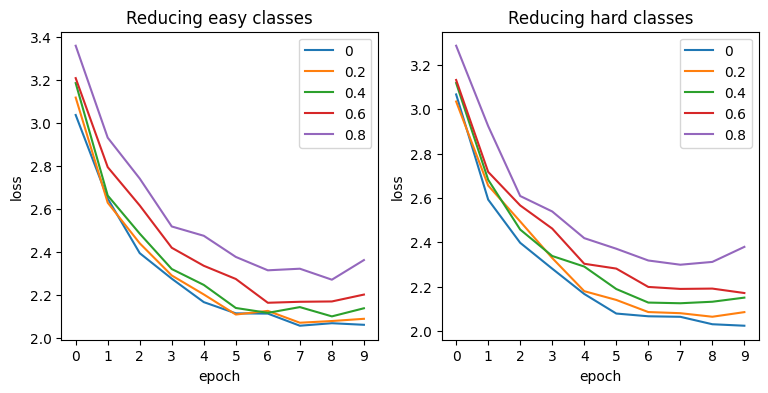

In [26]:
fig,axes = plt.subplots(1,2,figsize=(9, 4))
for fraction in fractions:
    axes[0].plot(range(N_EPOCHS),tensor_list_to_list(modes_history['easy'][fraction]['test']),label=str(fraction))
    axes[1].plot(range(N_EPOCHS),tensor_list_to_list(modes_history['hard'][fraction]['test']),label=str(fraction))
axes[0].legend()
axes[1].legend()
axes[0].set_title('Reducing easy classes')
axes[1].set_title('Reducing hard classes')
for ax in axes:
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    
axes[0].set_xticks([i for i in range(N_EPOCHS)]) 
axes[1].set_xticks([i for i in range(N_EPOCHS)])
fig.show()

In [25]:
train_loader,test_loader = get_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [26]:
train_losses = []
loss_function = nn.CrossEntropyLoss(reduction='none')
losses = []
with torch.no_grad():
  for x,y in train_loader:
    x,y = x.to(device), y.to(device)
    logits = model(x)
    batch_loss = loss_function(logits,y)
    losses.append(batch_loss)

loss_per_object = torch.hstack(losses)
loss_per_object.shape

torch.Size([50000])

In [27]:
indexes = np.argsort(tensor_list_to_list(loss_per_object))
indexes[:10]
#indexes show to sort train_data in ascending order
#so we can now sort our data 

array([31330, 42315, 10468,  2747,  1747, 25807, 40136, 30730, 35212,
       27548])

In [28]:
def get_reduced_loader(data_dir,mode,fraction,batch_size,augment=True, shuffle=True, args=None):
    '''
    mode = 'easy' or 'hard' -> what type of label we exclude
    fraction -> how many samples we exclude (and remains (1-fraction)*100% )
    the difference between this function and get_train_loader is in following:
    here we don't care about class labels,only about losses itself
    '''
    train_transform, test_transform = prepare_transforms(augments=[augment,False])
    data_dir = 'cifar-100'
    train_dataset = datasets.CIFAR100(data_dir, train=True, transform=train_transform, download=True)
    X_all,y_all = train_dataset.data, torch.LongTensor(train_dataset.targets)
    X_all_sampled = X_all[indexes]
    y_all_sampled = y_all[indexes]
    data_len = len(y_all)
    if mode == 'easy':
        train_dataset.data = X_all_sampled[int(fraction*data_len) :]
        train_dataset.targets = y_all_sampled[int(fraction*data_len) :]
    if mode == 'hard':
        train_dataset.data = X_all_sampled[: int((1-fraction)*data_len)]
        train_dataset.targets = y_all_sampled[: int((1-fraction)*data_len)]

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, shuffle=shuffle,
        pin_memory=True, num_workers=2,
    )
    return train_loader

In [29]:
train_loader = get_reduced_loader(data_dir,mode='easy',fraction=0.1,batch_size=32)

Files already downloaded and verified


In [30]:
length = 0
for _,y in train_loader:
    length += len(y)

length

45000

In [31]:
loss_function = nn.CrossEntropyLoss()

In [32]:
modes = ['easy', 'hard']
modes_history = {'easy':{},'hard':{}}
fractions = [0,0.1,0.2,0.3,0.4]

for fraction in fractions:
  for mode in modes:
    reduced_train_loader = get_reduced_loader(data_dir,mode=mode,fraction=fraction,batch_size=32)
    model = resnet18()
    model.fc = nn.Linear(512,100)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    model,losses = train_test_cycle(model,reduced_train_loader,test_loader,optimizer,scheduler,loss_function,n_epochs=N_EPOCHS)
    modes_history[mode][fraction] = losses

Files already downloaded and verified


100%|██████████| 313/313 [00:01<00:00, 172.42it/s]


Files already downloaded and verified


100%|██████████| 1563/1563 [00:25<00:00, 62.14it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 313/313 [00:02<00:00, 129.76it/s]


Files already downloaded and verified


100%|██████████| 313/313 [00:02<00:00, 131.79it/s]


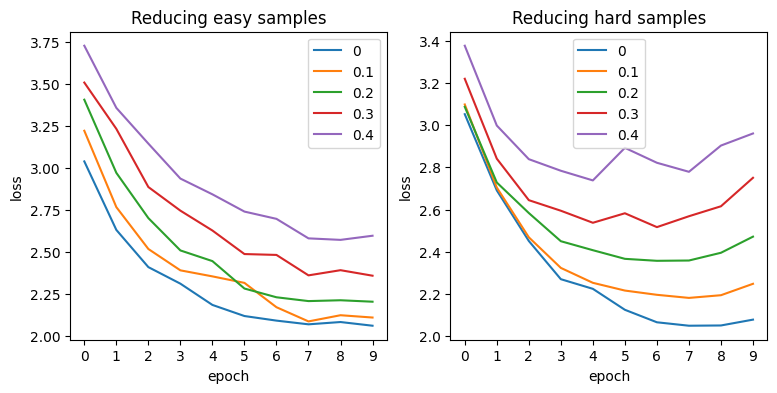

In [33]:
fig,axes = plt.subplots(1,2,figsize=(9,4))
for fraction in fractions:
    axes[0].plot(range(N_EPOCHS),tensor_list_to_list(modes_history['easy'][fraction]['test']),label=str(fraction))
    axes[1].plot(range(N_EPOCHS),tensor_list_to_list(modes_history['hard'][fraction]['test']),label=str(fraction))
axes[0].legend()
axes[1].legend()
axes[0].set_title('Reducing easy samples')
axes[1].set_title('Reducing hard samples')
for ax in axes:
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    
axes[0].set_xticks([i for i in range(N_EPOCHS)]) 
axes[1].set_xticks([i for i in range(N_EPOCHS)])
fig.show()